In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ase import Atoms
from tqdm import tqdm

from Constants import Keys, Dataset, Logging

In [2]:
data = np.load("./../Datasets/md17_aspirin.npz")
print(data.files)
data['E'].shape

['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']


(211762, 1)

In [6]:
def plot_loss(folder, molecule, long_range, skip=1):
    path = os.path.join("..", "Checkpoints", folder)
    # if not exist return
    if not os.path.exists(path) or not os.path.isdir(path):
        print(f"Folder {folder} does not exist")
        return
    log_path = os.path.join(path, "training_log.csv")
    # create dir for plots
    os.makedirs(os.path.join(path, "plots"), exist_ok=True)
    
    # load csv file with pandas
    log = pd.read_csv(log_path)
    
    # skip first epochs to get a better visualization of the loss
    log = log[skip:]
    
    # display total loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_total_loss_key], label='Train Total Loss')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_total_loss_key], label='Validation Total Loss')
    except KeyError:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", f"{molecule}_{long_range}_total_loss.pdf"))
    plt.show()
    
    # display energy loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_energy_loss_key], label='Train MSE Loss')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_energy_loss_key], label='Validation MSE Loss')
    except KeyError:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Loss (kcal/mol)^2')
    plt.legend()
    plt.title("Energy Loss without Long Range Interaction")
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", f"{molecule}_{long_range}_energy_loss.pdf"))
    plt.show()
    
    # display force loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_force_loss_key], label='Train Force Loss (kcal/mol/Å)')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_force_loss_key], label='Validation Force Loss (kcal/mol/Å)')
    except KeyError:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", f"{molecule}_{long_range}_force_loss.pdf"))
    plt.show()
    
    # display weights
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.p_energy_key], label='P Energy')
    plt.plot(log[Logging.epoch_key], log[Logging.p_force_key], label='P Force')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", f"{molecule}_{long_range}_weights.pdf"))
    plt.show()

In [22]:
def plot_energy_loss(folder, molecule, long_range, skip=1):
    path = os.path.join("..", "Checkpoints", folder)
    # if not exist return
    if not os.path.exists(path) or not os.path.isdir(path):
        print(f"Folder {folder} does not exist")
        return
    log_path = os.path.join(path, "training_log.csv")
    
    # load csv file with pandas
    log = pd.read_csv(log_path)
    
    # skip first epochs to get a better visualization of the loss
    log = log[skip:]
    
    # display energy loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_energy_loss_key], label='Train MSE Loss')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_energy_loss_key], label='Validation MSE Loss')
    except KeyError:
        pass
    font_size = 16
    plt.xlabel('Epoch', fontsize=font_size)
    plt.ylabel('Loss (kcal/mol)^2', fontsize=font_size)
    plt.xticks(fontsize=font_size-1)
    plt.yticks(fontsize=font_size-1)
    plt.legend(loc="upper right", fontsize=font_size)
    plt.title(f"Energy Loss {molecule} {'with Long-Range' if long_range else 'without Long-Range'}", fontsize=font_size)
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=4)
    plt.savefig(f"{molecule}_{'long_range' if long_range else 'no_long_range'}_energy_loss.pdf")
    plt.show()

Fixed prefactor scheme

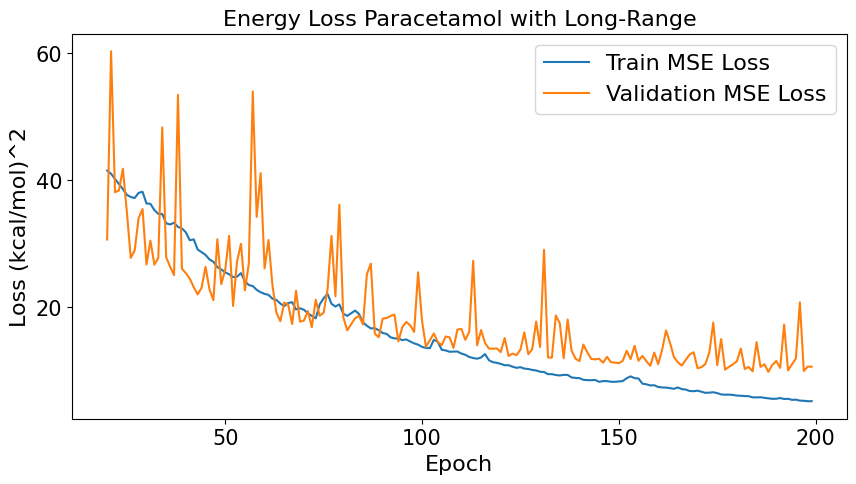

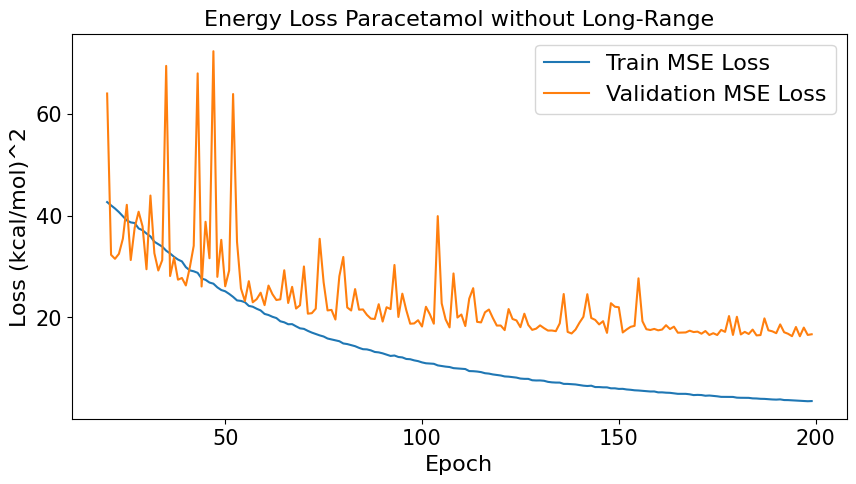

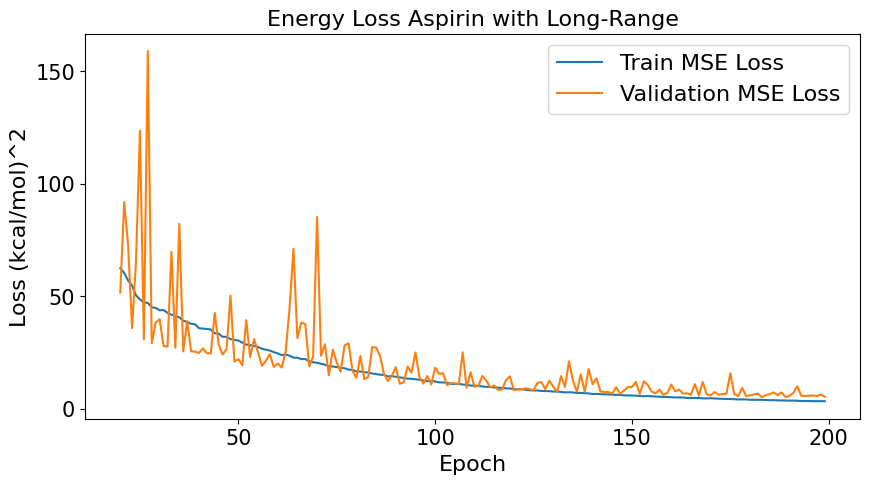

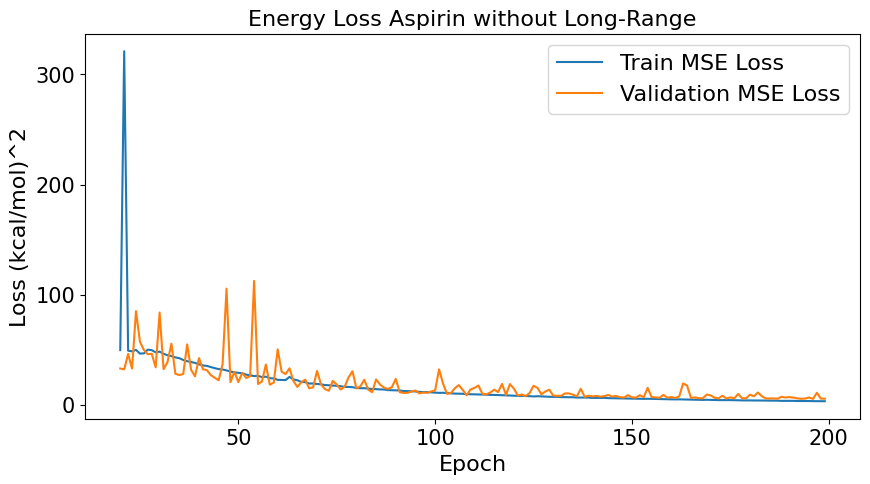

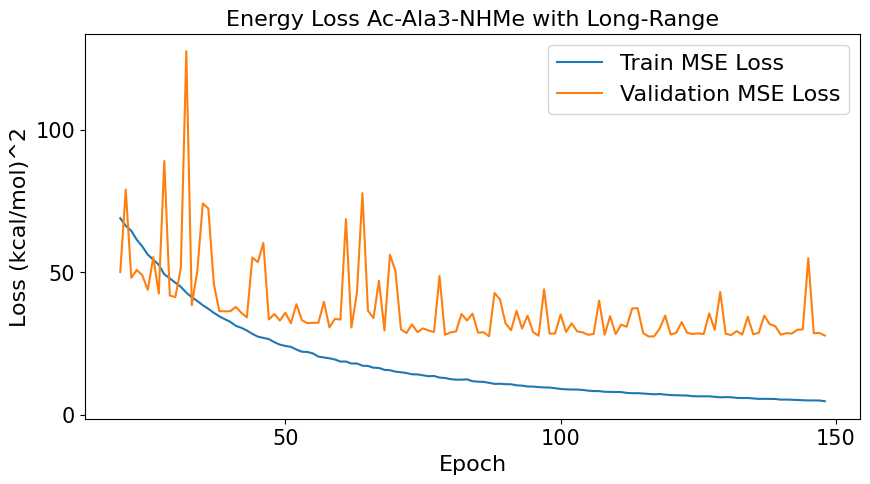

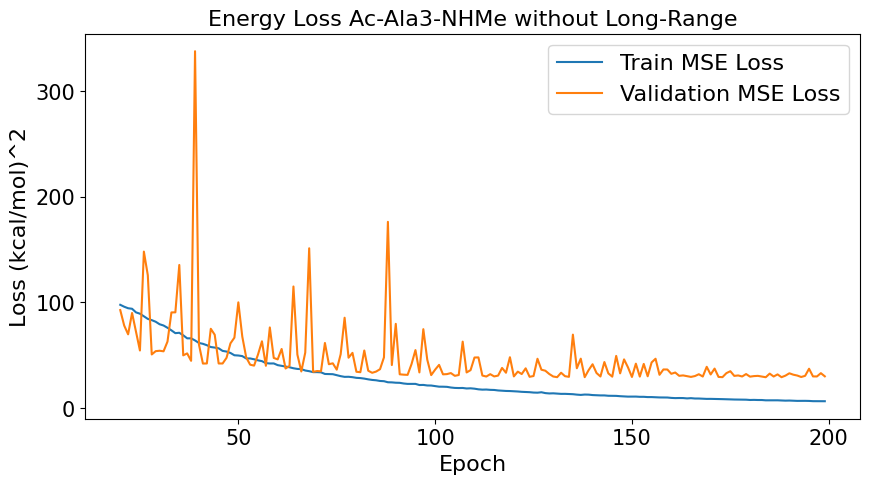

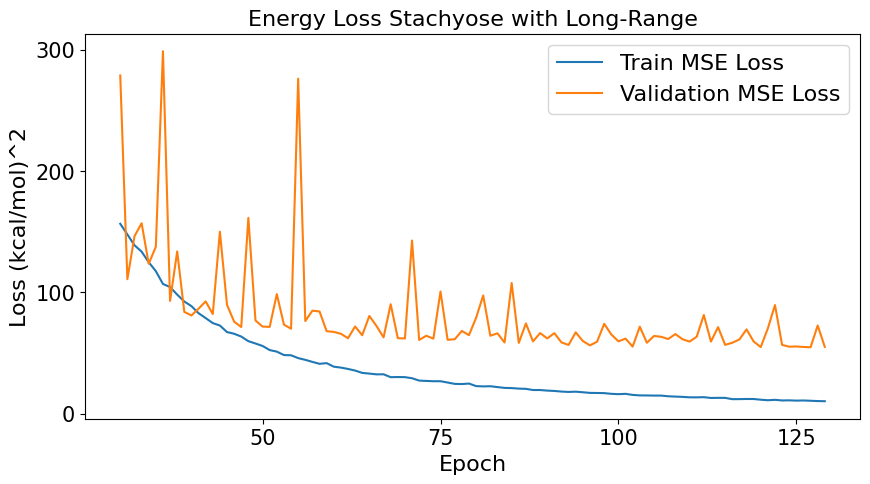

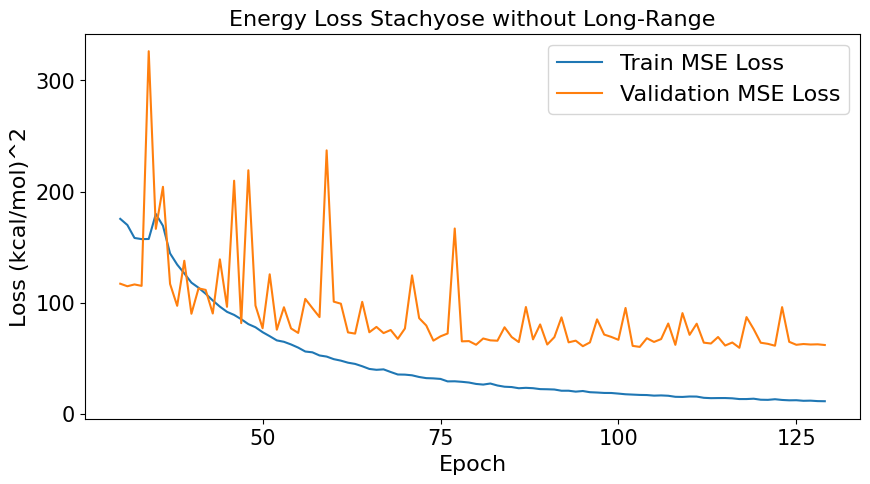

In [23]:
# Paracetamol
plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Paracetamol\Model-paracetamol_max_local_level_6_grid_size_1-DS-5e-05-lr-208000.0-decay-steps23-21-36", 
    "Paracetamol",
    long_range=True,
    skip=20
)

plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Paracetamol\Model-paracetamol_max_local_level_6_grid_size_1-DS-5e-05-lr-208000.0-decay-steps17-57-14_no_long_range", 
    "Paracetamol",
    long_range=False,
    skip=20
)

# Aspirin
plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Aspirin\1. Run\Model-aspirin_max_local_level_6_grid_size_1-DS-0.0001-lr-208000.0-decay-steps19-56-15", 
    "Aspirin",
    long_range=True,
    skip=20
)

plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Aspirin\1. Run\Model-aspirin_max_local_level_6_grid_size_1-DS-0.0001-lr-208000.0-decay-steps08-28-24_no_long_range", 
    "Aspirin",
    long_range=False,
    skip=20
)

# Ac-Ala3-NHMe
plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Ac\Model-Ac-Ala3-NHMe_max_local_level_2_grid_size_2-DS-5e-05-lr-208000.0-decay-steps13-40-55", 
    "Ac-Ala3-NHMe",
    long_range=True,
    skip=20
)

plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Ac\Model-Ac-Ala3-NHMe_max_local_level_2_grid_size_2-DS-0.0001-lr-208000.0-decay-steps19-48-11_no_long_range", 
    "Ac-Ala3-NHMe",
    False,
    skip=20
)

# Stachyose
plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Stachyose\Model-stachyose_max_local_level_4_grid_size_2-DS-5e-05-lr-87270.0-decay-steps11-01-04", 
    "Stachyose",
    long_range=True,
    skip=30
)

plot_energy_loss(
    r"D:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\Checkpoints\Stachyose\Model-stachyose_max_local_level_4_grid_size_2-DS-5e-05-lr-87270.0-decay-steps20-54-08_no_long_range", 
    "Stachyose",
    long_range=False,
    skip=30
)

In [12]:
path = os.path.join("..", "Datasets", "aspirin_grid_size_1.5_n_samples_40000", "val.pkl.gzip")
df = pd.read_pickle(path, compression="gzip")
df.head()

,energy,forces,atomic_numbers,positions,local_distance_matrix,local_atomic_numbers,long_range_distance_matrix,long_range_atomic_features,n_max_local,n_max_long_range
9,-406747.383296,"[[7.687831584094503, -25.23848389743499, 4.730...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.25371432, -0.38405914, 0.25593283], [0.836...","[[[2.8270380008208646, 0.5013029430762862, -0....","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.846670732028887, 0.9904143114167501, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,14
55,-406741.957874,"[[-42.38533110425632, -30.740087767996194, -10...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.36304368, -0.34213535, 0.21691393], [0.862...","[[[2.775653414030076, 0.5404691567099756, -0.8...","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.953913521834249, 0.9781520677953967, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,15
60,-406743.807567,"[[-49.782884695510745, -27.88165693154364, -14...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.34522732, -0.32257084, 0.20605715], [0.864...","[[[2.743495996530941, 0.5397548098748607, -0.8...","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.913194210199719, 0.9785167167865244, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,17
77,-406741.607621,"[[45.35561749916785, -27.066443318838452, 12.9...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.24354799, -0.3121744, 0.15801046], [0.8158...","[[[2.697646642702258, 0.5292561996073041, -0.8...","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.736282338454301, 0.9783820334205712, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,15
82,-406740.760367,"[[55.41289478105389, 4.124412729455345, 14.450...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.22367626, -0.32715976, 0.14638931], [0.812...","[[[2.7053229515186494, 0.5214812668513579, -0....","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.717098302841191, 0.9775565909659857, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,15


In [13]:
import tensorflow as tf

In [15]:
c = tf.constant(1.0, dtype=tf.float32)
c+1

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>